In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.shape

(7613, 5)

In [4]:
# Keyword counts
counts = df['keyword'].value_counts(dropna=False)

for value, count in counts.items():
    print(f'{value}: {count}')

nan: 61
fatalities: 45
deluge: 42
armageddon: 42
sinking: 41
damage: 41
harm: 41
body%20bags: 41
evacuate: 40
fear: 40
outbreak: 40
siren: 40
twister: 40
windstorm: 40
collided: 40
sinkhole: 39
sunk: 39
hellfire: 39
weapon: 39
weapons: 39
famine: 39
explosion: 39
whirlwind: 39
earthquake: 39
derailment: 39
wreckage: 39
collision: 39
flames: 39
wrecked: 39
ambulance: 38
injury: 38
hurricane: 38
flooding: 38
fire: 38
fatal: 38
blaze: 38
explode: 38
drowned: 38
thunder: 38
derailed: 38
typhoon: 38
deaths: 38
upheaval: 38
oil%20spill: 38
bombed: 38
emergency: 37
pandemonium: 37
hostages: 37
wounded: 37
debris: 37
ruin: 37
burning%20buildings: 37
sandstorm: 37
wreck: 37
blizzard: 37
curfew: 37
crush: 37
fatality: 37
bioterror: 37
mudslide: 37
quarantined: 37
police: 37
destroy: 37
panic: 37
floods: 36
displaced: 36
devastation: 36
screaming: 36
nuclear%20reactor: 36
dust%20storm: 36
ablaze: 36
attack: 36
engulfed: 36
evacuated: 36
evacuation: 36
detonate: 36
tragedy: 36
death: 36
desolation

In [5]:
# Target class counts
counts = df['target'].value_counts(dropna=False)

for value, count in counts.items():
    print(f'{value}: {count}')

0: 4342
1: 3271


In [6]:
# Tweet counts (we can check for duplicates here)
counts = df['text'].value_counts(dropna=False)

for value, count in counts.items():
    print(f'{value}: {count}')

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...: 10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam: 6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.': 6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_: 6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: 5
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time: 4
To fight bioterrorism sir.: 4
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carryi...: 4
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; ho

Islamic State group threatens to kill hostage if Û÷Muslim womenÛª arenÛªt let go - http://t.co/48Zg5ynebn...: 1
That moth that held me hostage yesterday has been chilling on the bathroom windowsill all day and I'm not okay with this: 1
I always tell my mom to bring me food or I will hold her cat hostage??: 1
Û÷RansomwareÛª holds B.C. manÛªs computer files hostage: A virus locked Andrew Wilson's family photos and otherÛ_ http://t.co/aQbLjComlN: 1
Egyptian Militants Tied to ISIS Threaten to Kill Croatian Hostage (New York Times) http://t.co/GTXndnJRrl (1717 GMT): 1
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/UMgD92wLjA #prebreak #best: 1
Mom is hijacking my account to earn MCR STATUS!!!  Get your own account snort!  
http://t.co/jST5hAUK35 #FlavorChargedTea: 1
The Murderous Story Of AmericaÛªs First Hijacking http://t.co/LK5uqKOP1e: 1
How to Remove Softenza Hijacker? Softenza Anthelmintic Nature book Drawing out Help SEA: 1
Remove 

@kasiakosek the drive sucks in my case because I know my desk looks like a war zone and then everyone goes into the 'I need this' mode: 1
'The Reagan Administration had arranged for Israeli weapons to be sent to the Guatemalan Army  http://t.co/4fYNQ1hWWb: 1
In memory of the victims of Hiroshima and Nagasaki. Never again! Ban nuclear weapons! : https://t.co/J3cIRXjFa6: 1
Hey all you love birds! We have been getting submissions for the Whirlwind Wedding Wars and they are so fantastic! Keep sending them guys!: 1
I honestly wonder what it is that I had to do so wrong to lose everyone.: 1
Dr. Bengston on #wildfire management: ÛÏnumbers and size of fires areas affected and costs of fighting them all show upward trend.Û #smem: 1
Wildfire Burns On California U.s. China Economic Net Û_ : http://t.co/U2dO2mC2ri  http://t.co/3oM3xw6CZ8: 1
California is battling its scariest 2015 wildfire so far. http://t.co/Lec1vmS7x2: 1
Is LA at Risk for a Giant Wildfire? - Which Way L.A.? on KCRW http://t.

On holiday to relax sunbathe and drink ... Putting out bush fires? Not so much ?? #spain https://t.co/dRno7OKM21: 1
@LasVegasLocally @VitalVegas They reined it in to 3 drinks each for 2 people but only on account of too many falling-off-stool casualties!: 1
There might be casualties tomorrow: 1
The more I listen to it the more I believe Casualties of Cool is one of the best albums there ever was.: 1
'American Weapons and Support Are Fueling a Bloody Air War in Yemen' http://t.co/7aGeAkVn2x: 1
Cos sanity brings no reward for one more hit and one last score... Don't be a casualty cut the cord...: 1
Was '80s New #Wave a #Casualty of #AIDS?: Tweet And Since theyÛªd grown up watching DavidÛ_ http://t.co/qBecjli7cx: 1
Property/casualty insurance rates up 1% in July: After several months of no movement commercial property/casu... http://t.co/KcLkoKqI8a: 1
Being able to stay out of work this week to take online courses for the Property and Casualty StateÛ_ https://t.co/jmD7zwKSDM: 1
We're #

YOUR PHONE IS SPYING ON YOU! Hidden Back Door NSA Data Mining Software | THE FINANCIAL ARMAGEDDON BLOG http://t.co/qyCw5JJaj1: 1
'If I'd have had a long coat to hand I'd have worn it. The certainty of armageddon bears a sense of occasion.': 1
//im gonna beat armageddon as Hsu Hao ????
just got a flawless on my first try: 1
'Show Me a Hero': TV Review http://t.co/KaCCPk85wf http://t.co/NniXodHIGc: 1
RT @Ophiuchus2613: #Love #TrueLove #romance lith  #Voodoo #seduction #Astrology #RTRRT #LOTZ 9-11 #apocalypse #Armageddon #1008plaÛ_: 1
@KatieKatCubs you already know how this shit goes. World Series or Armageddon.: 1
Red Faction: Armageddon  (Microsoft Xbox 360 2011) - Full read by eBay http://t.co/ypbVS1IJya http://t.co/9dFLv6ynqr: 1
Bed time. Don't wake me up unless revolution or Armageddon start.: 1
Best movie you've ever seen? - Armageddon  http://t.co/qoUXIgdtbZ: 1
ouvindo Peace Love &amp; Armageddon: 1
((OFFICIAL VID)) #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Pr

@TfLBusAlerts @TfLBusAlerts The Drive in Ilford closed both ways while emergency services deal with a call out. Buses are now stuck.: 1
@chillimik @HushLegs haha ??????..Are you really comparing yourselves to the emergency services! Thats brilliant! talk about up your own arse!: 1
@chrisroth98 @chaselabsports in an emergency situation late in the year. Not as a plan in camp: 1
County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy: 1
Storm concludes City of Calgary's Municipal Emergency Plan deactivated http://t.co/93iaEec26T: 1
The Municipal Emergency Plan is now in effect. Stay safe everyone! #abstorm #yyc http://t.co/14CIcptKNa: 1
City of Calgary activates municipal emergency plan as more thunderstorms approach http://t.co/8iHucO4GLW: 1
A big issue left undone is HOW to get home if adverse weather hits. @GoTriangle has no real emergency plan in place https://t.co/s7xdXuudcy: 1
Do you have an emergency drinking water

Wrinkled the face of deluge as decayed;: 1
Interesting: MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ... - ABC ... http://t.co/950xIJhnVH Please RT: 1
MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ... - ABC Onlin... http://t.co/N3lNdJKYo3 G #Malaysia #News: 1
Plane debris is from missing MH370 http://t.co/kxy56FR8vM: 1
Confirmed the debris from MH370 ??: 1
#?? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ...  http://t.co/MRVXBZywd4: 1
Malaysia Airlines Flight 370 that Disappeared 17months ago Debris Found South of The Indian Ocean - http://t.co/nrHURYSyPd: 1
#aerospace #exec Plane debris is from missing MH370 - Part of the aircraft wing found on Reunion Island is from th... http://t.co/S2wm8lh7oO: 1
@MayorofLondon pls reduce cyclist deaths with a compulsory highway code test as with EVERY OTHER VEHICLE that uses a road. #notrocketscience: 1
Bigamist and his 'first' wife are char

Did Josephus get it wrong about Antiochus Epiphanes and the Abomination of Desolation? Read more: http://t.co/FWj9CcYw6k: 1
Watching 'The Desolation of Smaug' in Spanish is a hell of a drug: 1
Wow! I just won this for free The Hobbit: Desolation of Smaug UV digital download code *GIN 9 http://t.co/MjFdCrjs8j #listia: 1
RT kurtkamka: Beautiful desolation. Just me a couple of coyotes some lizards and the morning sun. #Phoenix #ArizÛ_ http://t.co/0z1PvJVdpf: 1
RT @FreeDiscountBks: **Desolation Run** #FREE till 8/7! http://t.co/AxVqldTeHC #Military #Thriller #Suspense #Kindle #amreading http://tÛ_: 1
Isai 60:1; Psm 138:8
 Every conspiracy against my lifting be scattered unto desolation in the name o f Jesus.: 1
I rated The Hobbit: The Desolation of Smaug (2013) 7/10  #IMDb http://t.co/dJDeWd13wR: 1
i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug: 1
Just came back from camping and returned with a new song which gets recorded tomorrow

In [7]:
# Pre-Processing

# Only leave necessary characters in tweets
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9@ ]', '', regex=True)

# Convert all tweets to lowercase
df['text'] = df['text'].str.lower()

# Convert tweets with more than 2 repeating characters to just 2
df['text'] = df['text'].str.replace(r'(.)(\1+)', r'\1\1', regex=True)

# Convert all urls to 'URL'
df['text'] = df['text'].str.replace(r'http\S+', 'URL', regex=True)

# Convert all @ user mentions to 'USER'
df['text'] = df['text'].str.replace(r'@\S+', 'USER', regex=True)

# Remove duplicate tweets
df = df.drop_duplicates(subset=['text'])

# Remove location column
df = df.drop(columns=["location"])

# # Remove rows where keyword is blank
# df = df.dropna(subset=['keyword'])

# # Add numerical representation of keyword column
# label_encoder = LabelEncoder()
# df['keyword_num'] = label_encoder.fit_transform(df['keyword'])

df.shape

(6924, 4)

In [9]:
df.head()

,id,keyword,text,target
0,1,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,1300 people receive wildfires evacuation order...,1
4,7,NaN,just got sent this photo from ruby alaska as s...,1


In [85]:
%%time
# Generate embeddings for tweets
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')
#sent_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #embeddings1

def embedding(texts):
    embs = sent_model.encode(texts)
    return embs

n_cores = 4
batch_size = 64

def process_batch(i):
    batch_texts = df['text'].iloc[i:i+batch_size].tolist()
    batch_embeddings = embedding(batch_texts)
    return batch_embeddings

# embeddings = Parallel(n_jobs=n_cores)(
#     delayed(process_batch)(i) for i in range(0, len(df), batch_size))

# flat_embeddings = [emb for batch in embeddings for emb in batch]
# df['embeddings'] = flat_embeddings

# embedding_data = torch.tensor(np.vstack(df['embeddings'].values), dtype=torch.float32)
# torch.save(embedding_data, 'embeddings.pt')

CPU times: total: 1min 34s
Wall time: 3min 2s


In [11]:
def validate(model, dataloader):
    model.eval()
    val_losses = []
    val_targets = []
    val_predictions = []
    
    for inputs, labels in dataloader:
        with torch.no_grad():
            # Calculate val metrics
            outputs = model(inputs)
            # Version for averaging losses across batches
            #loss = F.binary_cross_entropy(outputs, labels)
            #v_losses.append(loss)
            # Version for getting every loss individually
            loss_val = F.binary_cross_entropy(outputs, labels, reduction='none')
            for idx in range(loss_val.shape[0]):
                val_losses.append(loss_val[idx].mean())
            val_predictions.append(outputs.numpy())
            val_targets.append(labels.numpy())

    val_avg_loss = np.array(val_losses).mean()
    #print("Val Loss:", val_avg_loss)

    val_predictions = np.vstack(val_predictions)
    val_targets = np.vstack(val_targets)

    # Binary classification metrics
    accuracy_val = metrics.accuracy_score(val_targets, (val_predictions > 0.5).astype(int))
    #print(f'Accuracy: {accuracy_val:.4f}')
    #print()
    
    return val_avg_loss


def visualize_val(i, epochs, loss, dataloader):
        print(f'{i:3d}/{epochs:3d}: {loss.item():.6f}')
        #print("Curr LR:", opt.param_groups[0]['lr'])
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Visualize a few val examples during epoch updates
                viz_data = inputs[:3]
                viz_labels = labels[:3]

                out_viz = model(viz_data)

                for ct in range(out_viz.shape[0]):
                    loss_viz = F.binary_cross_entropy(out_viz[ct], viz_labels[ct])
                    print("Loss:", loss_viz)
                    print("Pred:", out_viz[ct].numpy())
                    print("Pred:",  (out_viz[ct] > 0.5).float().numpy())
                    print("Targ:", viz_labels[ct].numpy())
                    print()
                break

In [122]:
# Set seed for reproducibility
torch.manual_seed(4975)

#keyword_data = torch.tensor(df['keyword_num'].values, dtype=torch.float32)
embedding_data = torch.tensor(np.vstack(df['embeddings'].values), dtype=torch.float32)
embedding_data1 = torch.tensor(np.vstack(df['embeddings1'].values), dtype=torch.float32)


#combined_data = torch.cat((keyword_data.reshape(-1,1), embedding_data), axis=1)
targets = torch.tensor(df['target'].values, dtype=torch.float32).reshape(-1,1)

# Input-independent baseline
# zero_x = torch.zeros_like(combined_data)
# dataset = TensorDataset(zero_x, labels)

# Overfit one batch
# combined_data = combined_data[:3]
# labels = labels[:3]

# Create train, val, and test DataLoaders
#dataset = TensorDataset(combined_data, targets)
#dataset = TensorDataset(embedding_data, targets)
dataset = TensorDataset(embedding_data1, targets)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_hidden1 = 16
n_hidden2 = 8

model = torch.nn.Sequential(
    #torch.nn.Linear(385, n_hidden1, bias=False),
    #torch.nn.Linear(384, n_hidden1, bias=False),
    torch.nn.Linear(768, n_hidden1, bias=False),
    torch.nn.BatchNorm1d(n_hidden1),
    #torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden1, n_hidden2, bias=False),
    torch.nn.BatchNorm1d(n_hidden2),
    #torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden2, 1, bias=True),
    torch.nn.Sigmoid()
)

# Implement proper weight initialization
def initialize_weights(model):
    for layer in model[:-2]:
        if isinstance(layer, torch.nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
    # Init last layer with xavier as it has a sigmoid activation instead of ReLU
    torch.nn.init.xavier_normal_(model[-2].weight, gain=1.0)

initialize_weights(model)

# Make last layer less confident (Not sure about adding this yet)
with torch.no_grad():
    model[-2].weight *= 0.1
    
######################################## Diagnostics ########################################
    
# Retain relu outputs for diagnostics
last_relu_outputs = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))
last_relu_grads = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))

hook_handles = []

def hook_fn_back(index):
    def fn_b(module, grad_in, grad_out):
        last_relu_grads[index] = grad_out[0].clone()
    return fn_b

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_full_backward_hook(hook_fn_back(layer_index)))
        layer_index += 1

def hook_fn(index):
    def fn(module, inputs, outputs):
        last_relu_outputs[index] = outputs
    return fn

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_forward_hook(hook_fn(layer_index)))
        layer_index += 1
        
def compute_ratio(parameter, lr):
    gradient_std = parameter.grad.std()
    data_std = parameter.data.std()  # Calculate data standard deviation for the same layer
    ratio = (lr * gradient_std / data_std).log10().item()
    return ratio

#############################################################################################
    
# Ran into a funny error here. You have to wrap it in a list because
# model.parameters() is an iterator and after you go over it first it
# becomes exhausted so in all the code below after I went through and
# counted the parameters the 'parameters' iterator became empty and 
# everything after was just operating on an empty list
parameters = list(model.parameters())

# Total number of parameters
print("Parameters:",sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Parameters: 12473


In [123]:
# Check for ~correct~ initialization
# For binary classification using BCELoss you have either a 0 or a 1 where the predictions are probabilities and generally 
# > 0.5 (or some other threshold) is treated as a 1 label. Therefore exactly 0.5 would be "no preference" so in theory 
# the correct init would be to start off with predicting a probability of exactly 0.5 and the loss of this would be 0.6931 
# because the bce equation is 'loss = - (y * np.log(p) + (1 - y) * np.log(1 - p))' and when the predicted probability is 
# exactly 0.5 you end up with the same result regardless of the target which is 0.6931. So any loss value roughly around 
# 0.6931 would be a decent start
model.eval()

with torch.no_grad():
    #dummy_input = torch.randn(2,385)
    #dummy_input = torch.randn(2,384)
    dummy_input = torch.randn(2,768)
    out = model(dummy_input)

    init_loss = F.binary_cross_entropy(out, torch.zeros_like(out), reduction='none')

    print("Init loss mean:", init_loss.mean())
    print()
    print("Init loss all:", init_loss)

Init loss mean: tensor(0.6120)

Init loss all: tensor([[0.6581],
        [0.5658]])


In [124]:
################## RERUN INIT CODE BEFORE TRAINING ##################

# same optimization as last time
model.train()

#opt = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.2)
opt = optim.Adam(model.parameters(), lr=0.0003)
#opt = optim.Adam(model.parameters(), lr=0.003)
#opt = optim.SGD(model.parameters(), lr=0.01)
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.01)
#opt = optim.SGD(model.parameters(), lr=0.001)

# Learning rate scheduler
#scheduler = StepLR(opt, step_size=500, gamma=0.1)

epochs = 200
patience = 5 # for early stopping
best_val_loss = float('inf')
counter = 0

# For tracking metrics
lossi = []
ud = []

for i in range(epochs):
    for inputs, labels in train_loader:
        
        # forward pass
        logits = model(inputs)
        loss = F.binary_cross_entropy(logits, labels, reduction='mean')
        #loss = logits[0][0] + 1 test to ensure things are being calculated across batches, fyi shut off batch norm lol

        # backward pass
        opt.zero_grad()
        loss.backward()

        # update: simple SGD
        opt.step()
        
        # Diagnostics
        with torch.no_grad():
            ud.append([compute_ratio(p, opt.param_groups[0]['lr']) for p in model.parameters()])

    #scheduler.step()
    
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    # Visualize val examples
    if i % 25 == 0 or i == (epochs-1): # print every once in a while
        visualize_val(i, epochs, loss, val_loader)
    
    # Validation
    val_loss = validate(model, val_loader)
    
    # Check if metric has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
    
    # If no metric improvement and patience is reached, stop training loop
    if counter >= patience:
        print(f"Early stopping after {i + 1} epochs. Best validation loss: {best_val_loss}")
        break
    
#     if i >= 100:
#         break # DEBUGGING

###### Diagnostics cleanup ######
for handle in hook_handles:
    handle.remove()

  0/200: 0.564775
Loss: tensor(0.5169)
Pred: [0.40361884]
Pred: [0.]
Targ: [0.]

Loss: tensor(0.5806)
Pred: [0.44041517]
Pred: [0.]
Targ: [0.]

Loss: tensor(0.7260)
Pred: [0.48385334]
Pred: [0.]
Targ: [1.]

Early stopping after 10 epochs. Best validation loss: 0.44792526960372925


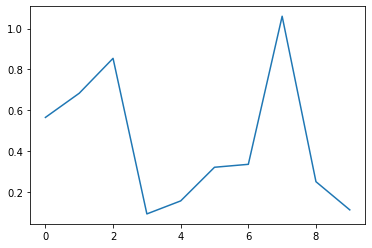

In [125]:
# Plot training losses
plt.plot(torch.tensor(lossi).view(-1, 1).mean(1))

In [126]:
model.eval()
t_predictions = []
t_targets = []
v_predictions = []
v_targets = []

threshold = 0.5

# Train Loss Calculations
with torch.no_grad():
    t_losses = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        loss = F.binary_cross_entropy(outputs, labels)
        t_losses.append(loss)
        # Version for getting every loss individually
#         loss = F.binary_cross_entropy(outputs, labels, reduction='none')
#         for idx in range(loss.shape[0]):
#             t_losses.append(loss[idx].mean())
        t_predictions.append(outputs.numpy())
        t_targets.append(labels.numpy())
        
train_avg_loss = np.array(t_losses).mean()
print("Train Loss:", train_avg_loss)

t_predictions = np.vstack(t_predictions)
t_targets = np.vstack(t_targets)

# Binary classification metrics
train_accuracy = metrics.accuracy_score(t_targets, (t_predictions > threshold).astype(int))
# train_precision = metrics.precision_score(t_targets, (t_predictions > threshold).astype(int), average='samples', zero_division=0)
# train_recall = metrics.recall_score(t_targets, (t_predictions > threshold).astype(int), average='samples')
train_f1 = metrics.f1_score(t_targets, (t_predictions > threshold).astype(int))
# train_roc_auc = metrics.roc_auc_score(t_targets, t_predictions, average='samples')

print(f'Accuracy: {train_accuracy:.4f}')
# print(f'Precision: {train_precision:.4f}')
# print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')
# print(f'ROC AUC: {train_roc_auc:.4f}')
print()

# Validation Loss Calculations
with torch.no_grad():
    v_losses = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        #loss = F.binary_cross_entropy(outputs, labels)
        #v_losses.append(loss)
        # Version for getting every loss individually
        loss = F.binary_cross_entropy(outputs, labels, reduction='none')
        for idx in range(loss.shape[0]):
            v_losses.append(loss[idx].mean())
        v_predictions.append(outputs.numpy())
        v_targets.append(labels.numpy())
        
val_avg_loss = np.array(v_losses).mean()
print("Val Loss:", val_avg_loss)

v_predictions = np.vstack(v_predictions)
v_targets = np.vstack(v_targets)

# Binary classification metrics
accuracy = metrics.accuracy_score(v_targets, (v_predictions > threshold).astype(int))
# precision = metrics.precision_score(v_targets, (v_predictions > threshold).astype(int), average='samples', zero_division=0)
# recall = metrics.recall_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
f1 = metrics.f1_score(v_targets, (v_predictions > threshold).astype(int))
# roc_auc = metrics.roc_auc_score(v_targets, v_predictions, average='samples')

print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
# print(f'ROC AUC: {roc_auc:.4f}')

Train Loss: 0.3210934
Accuracy: 0.8622
F1-score: 0.8262

Val Loss: 0.45864797
Accuracy: 0.7905
F1-score: 0.7259


new2
Train Loss: 0.35053396
Accuracy: 0.8516
F1-score: 0.8058

Val Loss: 0.4538591
Accuracy: 0.8006
F1-score: 0.7229

new 1
Train Loss: 0.33811817
Accuracy: 0.8577
F1-score: 0.8132

Val Loss: 0.45525178
Accuracy: 0.8020
F1-score: 0.7243

old
Train Loss: 0.367222
Accuracy: 0.8422
F1-score: 0.7990

Val Loss: 0.46904838
Accuracy: 0.7832
F1-score: 0.7159

In [46]:
df.head()

,id,keyword,text,target,keyword_num,embeddings
31,48,ablaze,@bbcmtd Wholesale Markets ablaze,1,0,"[-0.048377912, -0.049907103, 0.04133054, -0.03..."
32,49,ablaze,We always try to bring the heavy #metal #RT,0,0,"[-0.07463726, 0.05587676, 0.061600532, 0.03275..."
33,50,ablaze,#AFRICANBAZE Breaking newsNigeria flag set abl...,1,0,"[0.010205037, 0.15618128, 0.0081423605, 0.0361..."
34,52,ablaze,Crying out for more Set me ablaze,0,0,"[-0.0298749, 0.041128084, 0.043661572, -0.0322..."
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,0,"[0.031006379, 0.015415147, 0.07900491, -0.0040..."


In [20]:
v_pred_float = (v_predictions > 0.5).astype(float)
mismatched_rows = np.where(v_targets != v_pred_float)[0]
print(len(mismatched_rows))

for row in mismatched_rows:
    tmp = (embedding_data == val_dataset[row][0])
    allone = (tmp == 1).all(dim=1)
    idx = torch.nonzero(allone, as_tuple=False).squeeze()
    if idx.dim() > 0:
        idx = idx[0].item()
    else:
        idx = idx.item()
    print(df.iloc[idx][2])
    print(idx)
    print(v_predictions[row])
    print(v_targets[row])
    print()

# ct = 0
# for tweet in df['text'].iloc[mismatched_rows]:
#     print(f'{mismatched_rows[ct]}: {tweet}')
#     ct += 1

153
USER  infosec rather you knew it or not your a firefighter  now days  you often  run into burning buildings deal with it
1111
[0.84408563]
[0.]

from recycling to only using nonhazardous chemicals holland 1916 continually strives to maintain an ecofriendly existence
3930
[0.27637553]
[1.]

slip sliding away  flash floods info for writers wtony nester USER writingtips URL
3699
[0.18084744]
[1.]

afghan peace talks in doubt after mullah omars death  financial times  mullah
1974
[0.66753036]
[0.]

biolab safety concerns grow fedex stops transporting certain specimens research facilities dumbfounded by action URL
542
[0.6960843]
[0.]

after a few years afloat pension plans start sinking again URL
5533
[0.20122059]
[1.]

army names 10th mountain units for iraq afghanistan deployments deeds URL
4594
[0.79303557]
[0.]

USER  do anything to fix that of the few people he had every trusted in his life charles was one of the casualties
1300
[0.24388696]
[1.]

hollywood movie about trapped min

USER the causes of federal failure are deeply structural and they will not be easily solved URL
5782
[0.7098455]
[0.]

the lightning out here is something serious
4370
[0.4148467]
[1.]

new roof and hardy upwindstorm inspection tomorrow URL
6734
[0.5121513]
[0.]

if trillion crosses the line a 3rd time he does a fieldwide attack that does instant kill damage
1867
[0.19790399]
[1.]

cyclist who collided with runner on roanoke greenway wins 300 civil verdict URL via USER
1568
[0.90635175]
[0.]

USER civil rights continued in the 60s and what about transgenerational trauma if anything we should listen to the americans
6237
[0.523023]
[0.]

final medinah update shot a 105 49 on front exploded with a 56 on back imkeepingmydayjob pic is famous 17 URL
3201
[0.40183192]
[1.]

rationing of food and water may also become necessary during an emergency such as a natural disaster or terror attack
4654
[0.9104469]
[0.]

USER i do feel sorry for him he is not a piece of meat he is a nice guy people d

In [112]:
df.iloc[6550][2:4]

text      @OriginalFunko @Spencers THUNDER BUDDYS THUNDE...
target                                                    1
Name: 6681, dtype: object

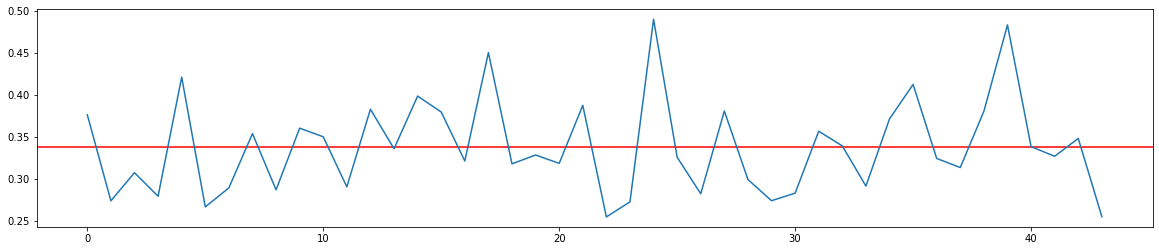

In [100]:
# For plotting train losses
plt.figure(figsize=(20,4))
plt.axhline(y = train_avg_loss, color = 'r', linestyle = '-') 
plt.plot(t_losses)

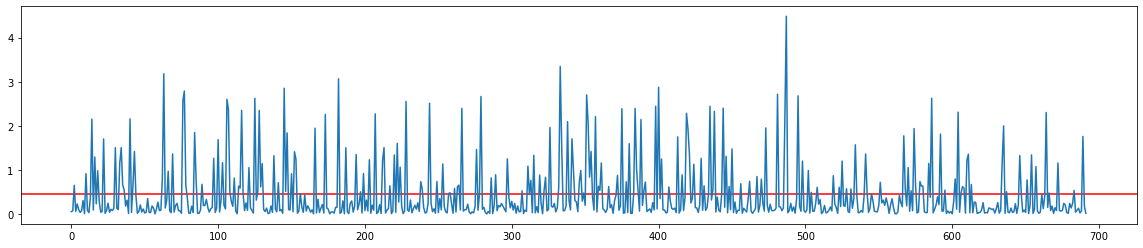

In [101]:
# For plotting val losses
plt.figure(figsize=(20,4))
plt.axhline(y = val_avg_loss, color = 'r', linestyle = '-') 
plt.plot(v_losses)

layer 0 ( RelU 0): mean +1.31, std 1.32, saturated: 22.12%
layer 1 ( RelU 1): mean +3.16, std 3.03, saturated: 16.35%


Text(0.5, 1.0, 'activation distribution')

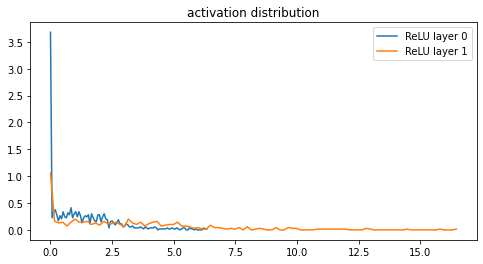

In [102]:
# Visualize Activation Distribution
plt.figure(figsize=(8, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_outputs):
    t = output
    print('layer %d (%7s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "RelU " + str(i), t.mean(), t.std(), (t == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    RelU 0): mean +0.000091, std 2.796556e-03
layer 1 (    RelU 1): mean -0.000136, std 1.428318e-03


Text(0.5, 1.0, 'gradient distribution')

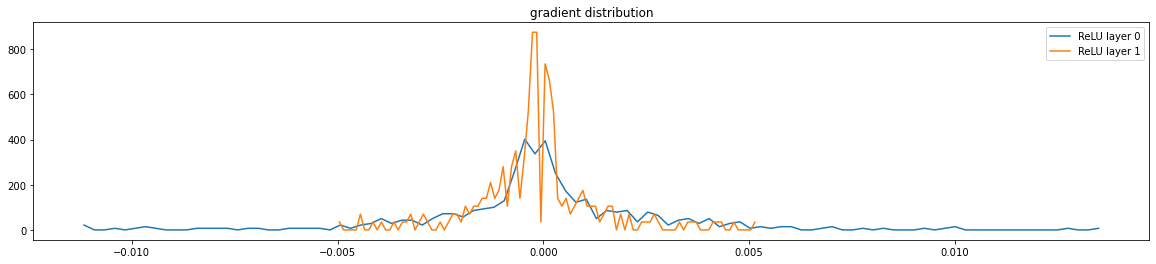

In [103]:
# Visualize Gradient Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_grads):
    t = output
    print('layer %d (%10s): mean %+f, std %e' % (i, "RelU " + str(i), t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    #hy /= hy.sum() # normalize, not sure about adding this yet. For consistency I'm leaving it out, may add later.
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends);
plt.title('gradient distribution')

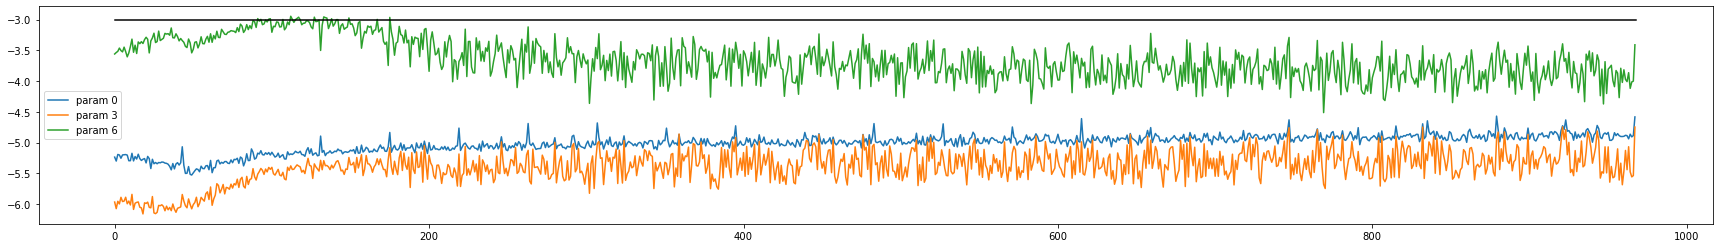

In [104]:
# Visualize Update-to-Data Ratio
plt.figure(figsize=(30, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### To-Do
##### Phase One
- [x] fix random seed
- [x] simplify
- [ ] add significant digits to eval
- [x] verify loss @ init
- [x] init well
- [ ] human baseline
- [x] input-independent baseline
- [x] overfit one batch
- [ ] verify decreasing training loss
- [x] visualize just before the net (this more so applies to image tasks)
- [x] visualize prediction dynamics (add to val loop)
- [x] use backprop to chart dependencies
- [x] generalize a special case

## Results Log
#### Model 1
- AdamW: 0.0003 Epochs: 3 Params: 56K Data: Original Batch: 32 Weight_Decay: 4 384 > 128 > 50 > 1
    - Train Loss: 0.3973235
    - Accuracy: 0.8519
    - Val Loss: 0.4735323
    - Accuracy: 0.7984

In [127]:
test_predictions = []
test_targets = []
threshold = 0.5

# Test Loss Calculations
with torch.no_grad():
    test_losses = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        #loss = F.binary_cross_entropy(outputs, labels)
        #test_losses.append(loss)
        # Version for getting every loss individually
        loss = F.binary_cross_entropy(outputs, labels, reduction='none')
        for idx in range(loss.shape[0]):
            test_losses.append(loss[idx].mean())
        test_predictions.append(outputs.numpy())
        test_targets.append(labels.numpy())
        
test_avg_loss = np.array(test_losses).mean()
print("Test Loss:", test_avg_loss)

test_predictions = np.vstack(test_predictions)
test_targets = np.vstack(test_targets)

# Binary classification metrics
accuracy = metrics.accuracy_score(test_targets, (test_predictions > threshold).astype(int))
# precision = metrics.precision_score(v_targets, (v_predictions > threshold).astype(int), average='samples', zero_division=0)
# recall = metrics.recall_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
f1 = metrics.f1_score(v_targets, (v_predictions > threshold).astype(int))
# roc_auc = metrics.roc_auc_score(v_targets, v_predictions, average='samples')

print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
# print(f'ROC AUC: {roc_auc:.4f}')

Test Loss: 0.44826043
Accuracy: 0.8052
F1-score: 0.7259


In [129]:
test_df = pd.read_csv('test.csv')

In [132]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [133]:
# Pre-Processing

# Only leave necessary characters in tweets
test_df['text'] = test_df['text'].str.replace(r'[^a-zA-Z0-9@ ]', '', regex=True)

# Convert all tweets to lowercase
test_df['text'] = test_df['text'].str.lower()

# Convert tweets with more than 2 repeating characters to just 2
test_df['text'] = test_df['text'].str.replace(r'(.)(\1+)', r'\1\1', regex=True)

# Convert all urls to 'URL'
test_df['text'] = test_df['text'].str.replace(r'http\S+', 'URL', regex=True)

# Convert all @ user mentions to 'USER'
test_df['text'] = test_df['text'].str.replace(r'@\S+', 'USER', regex=True)

# # Add numerical representation of keyword column
# label_encoder = LabelEncoder()
# test_df['keyword_num'] = label_encoder.fit_transform(test_df['keyword'])

test_df.shape

(3263, 4)

In [135]:
%%time
# Generate embeddings for tweets
#sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')
sent_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') #embeddings1

def embedding(texts):
    embs = sent_model.encode(texts)
    return embs

n_cores = 4
batch_size = 64

def process_batch(i):
    batch_texts = test_df['text'].iloc[i:i+batch_size].tolist()
    batch_embeddings = embedding(batch_texts)
    return batch_embeddings

embeddings = Parallel(n_jobs=n_cores)(
    delayed(process_batch)(i) for i in range(0, len(test_df), batch_size))

flat_embeddings = [emb for batch in embeddings for emb in batch]
test_df['embeddings1'] = flat_embeddings

test_embedding_data = torch.tensor(np.vstack(test_df['embeddings1'].values), dtype=torch.float32)
torch.save(test_embedding_data, 'test_embeddings1.pt')

CPU times: total: 2min 52s
Wall time: 11min 51s


In [136]:
def model_test(emb):
    model.eval()
    emb = torch.from_numpy(emb)
    with torch.no_grad():
        out = model(emb.reshape(1,-1))
        return (out > 0.5).int().item()
        
test_df['target1'] = test_df['embeddings1'].apply(model_test)

In [139]:
final = test_df[['id', 'target']]
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [140]:
final.to_csv('submission3.csv', index=False)